#  Brain-body-behavior descriptors ME

## Task and reference performance
**Carrier-v0** with a slight modification -> walk forward on an even terrain with an object on the back (object placed above the robot); usual performance around 10

## Descriptors recap
- Brain: (1) one arity functions / n nodes, (2) two arity functions / n nodes
- Body: (1) elongation, (2) n voxels / n max voxels
- Behavior: (1) y-velocity of object (median of fft), (2) % of contact with ground  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from qdax.utils.plotting import plot_2d_map_elites_repertoire
from scipy.stats import ranksums
%matplotlib inline

/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/giorgianadizar/miniconda3/envs/qdaxpy38/lib/python3.8/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.decl

In [2]:
dfs = []
for sampler in ["all", "s1", "s2", "s3"]:  #, "me"]:
    for seed in range(10):
        try:
            tmp_df = pd.read_csv(f"../results/me/evo-body-10x10-customcarrier-{sampler}_{seed}.csv")
            tmp_df["sampler"] = sampler
            tmp_df["seed"] = seed
            dfs.append(tmp_df)
        except FileNotFoundError:
            print(sampler, seed)
df = pd.concat(dfs)
df.head()

all 3
all 4
all 8
all 9
s1 3
s1 4
s1 8
s1 9
s2 3
s2 4
s2 7
s2 8
s2 9
s3 3
s3 4
s3 7
s3 8
s3 9


,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,sampler,seed
0,1,0.422962,-13.311106,-93.908130,-35.090250,1.367188,6.738281,3.613281,19.164813,2024-05-10 13:49:09.478785,all,0
1,2,0.719798,-10.278814,-119.289180,-40.668182,1.367188,8.691406,4.492188,8.929608,2024-05-10 13:49:18.408680,all,0
2,3,0.719798,-12.368221,-114.264620,-33.129610,1.464844,9.570312,4.882812,8.930643,2024-05-10 13:49:27.339689,all,0
3,4,0.719798,-5.667658,-116.556595,-27.965084,1.562500,10.839844,5.175781,9.178307,2024-05-10 13:49:36.518381,all,0
4,5,0.719798,-6.963644,-125.090090,-26.768436,1.660156,11.914062,5.566406,9.262639,2024-05-10 13:49:45.781355,all,0


In [3]:
final_df = df[df["iteration"] == max(df["iteration"])]
final_df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,sampler,seed
3999,4000,8.526160,212.59491,2130.1790,3085.4604,18.261719,54.882812,72.265625,9.243219,2024-05-11 00:11:02.889139,all,0
3999,4000,6.609180,191.35820,1461.4954,2301.2073,21.289062,56.933594,71.679690,9.856009,2024-05-12 19:09:50.621666,all,1
3999,4000,5.971713,87.74983,1386.0741,2182.8767,17.480469,54.492188,72.167970,10.147494,2024-05-14 16:08:52.536915,all,2
3999,4000,8.885994,198.71579,1557.7875,2675.5050,17.675781,52.148438,68.750000,10.330207,2024-05-11 05:27:39.129880,all,5
3999,4000,10.606979,352.94028,1931.6786,3631.5703,19.921875,53.613280,69.824220,11.142741,2024-05-13 07:23:29.886842,all,6


## Fitness results
- no convergence yet, how many more iterations would it require?
- sampling from all repertoires is better in median, but not statistically significant; joint ME follows immediately
- body diversity seems the least important for performance, does it depend on coverage/descriptors?

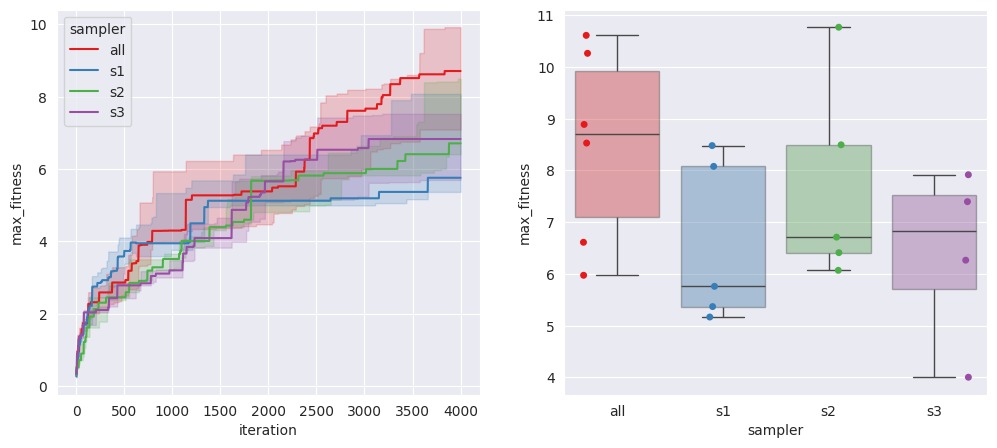

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(df,
             x="iteration",
             y="max_fitness",
             estimator="median",
             errorbar=("pi", 50),
             hue="sampler",
             palette="Set1",
             ax=axs[0]
             )
sns.boxplot(
    final_df,
    x="sampler",
    y="max_fitness",
    hue="sampler",
    palette="Set1",
    boxprops={'alpha': 0.4},
    ax=axs[1]
)
sns.stripplot(final_df,
              x="sampler",
              y="max_fitness",
              hue="sampler",
              palette="Set1",
              dodge=True,
              ax=axs[1])
plt.show()

In [5]:
pairs = []
for s1 in final_df.sampler.unique():
    for s2 in final_df.sampler.unique():
        if s1 != s2 and (s2, s1) not in pairs:
            pairs.append((s1, s2))
            fits1 = final_df[final_df["sampler"] == s1]["max_fitness"].to_list()
            fits2 = final_df[final_df["sampler"] == s2]["max_fitness"].to_list()
            _, p_value = ranksums(fits1, fits2)
            print(f"{s1} vs {s2} -> {p_value}")

all vs s1 -> 0.044609718024939606
all vs s2 -> 0.5838824207703652
all vs s3 -> 0.13559300126630222
s1 vs s2 -> 0.17452534056858338
s1 vs s3 -> 0.8064959405073401
s2 vs s3 -> 0.4624327264504764


## Coverage results
- sampling from repertoire x fosters diversity/coverage in x
- sampling from all repertoires is the second-best option for each, i.e., the best trade-off
- as before, ME has the worst coverage 

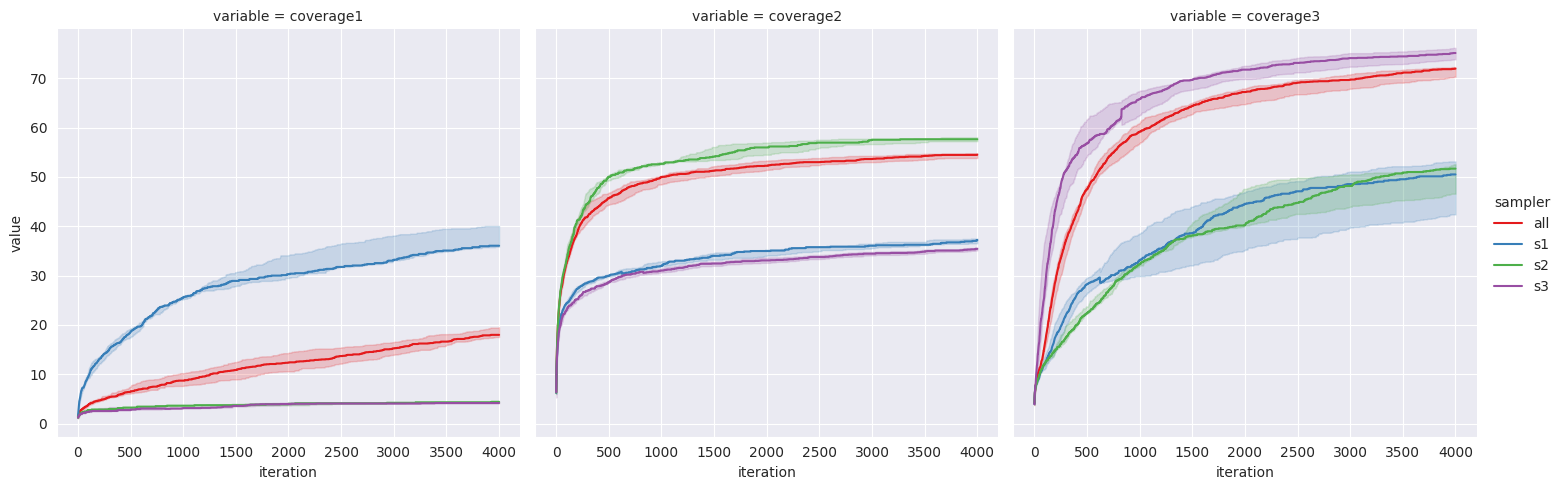

In [6]:
df_wide = pd.melt(df, id_vars=["iteration", "max_fitness", "time", "current_time", "sampler", "seed"],
                  value_vars=["coverage1", "coverage2", "coverage3"])
sns.relplot(df_wide,
            x="iteration",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="line",
            estimator="median",
            errorbar=("pi", 50),
            )
plt.show()

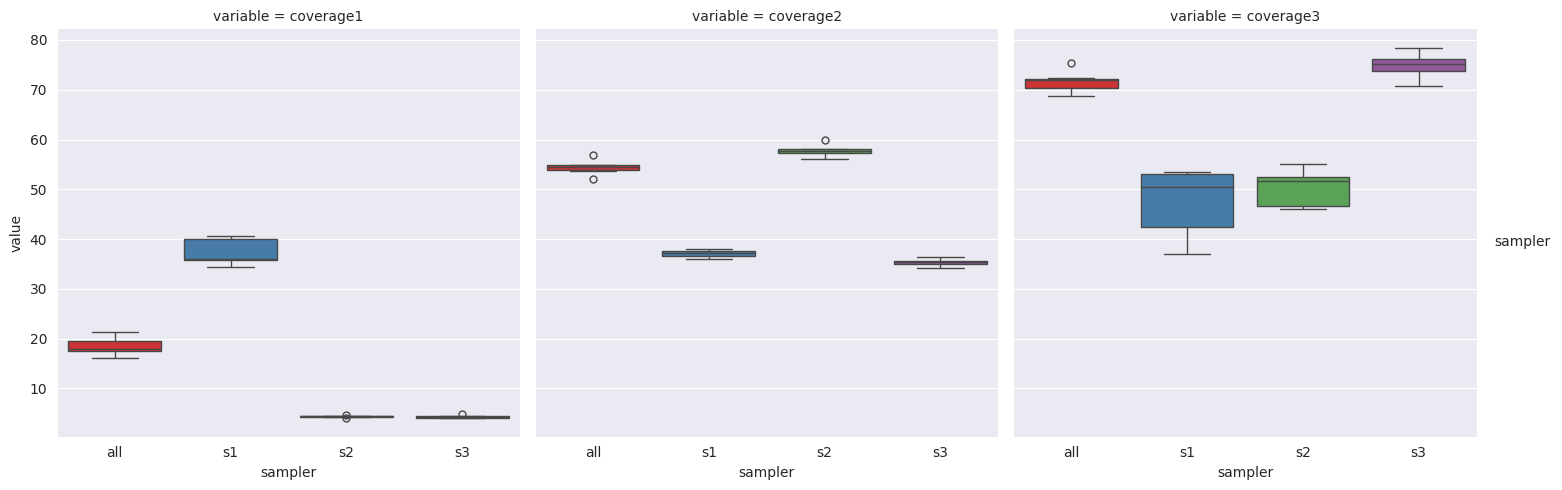

In [7]:
final_df_wide = df_wide[df_wide["iteration"] == max(df_wide["iteration"])]
sns.catplot(final_df_wide,
            x="sampler",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="box",
            )
plt.show()

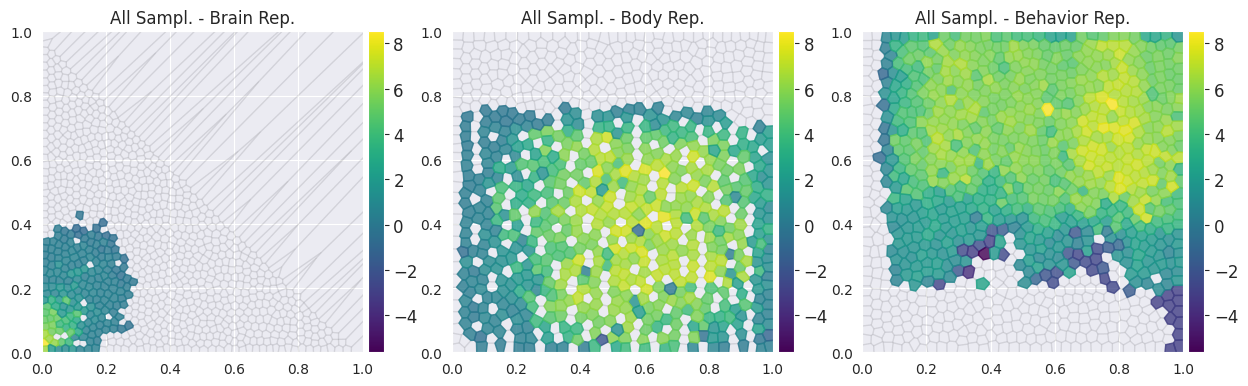

In [8]:
samplers = ["all"]
rep_seed = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
reps = {
    0: "Brain",
    1: "Body",
    2: "Behavior"
}
sams = {
    "all": "All",
}
min_fit, max_fit = jnp.inf, -jnp.inf
for i, sampler in enumerate(samplers):
    base_path = f"../results/me/evo-body-10x10-customcarrier-{sampler}_{rep_seed}"
    for r, ax in enumerate(axs):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        curr_min_fit, curr_max_fit = min(fitnesses[fitnesses > -jnp.inf]), max(fitnesses)
        if curr_min_fit < min_fit: min_fit = curr_min_fit
        if curr_max_fit > max_fit: max_fit = curr_max_fit

for i, sampler in enumerate(samplers):
    base_path = f"../results/me/evo-body-10x10-customcarrier-{sampler}_{rep_seed}"
    for r, ax in enumerate(axs):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        plot_2d_map_elites_repertoire(centroids, fitnesses, 0, 1, ax=ax, vmin=min_fit, vmax=max_fit)
        ax.set_title(f"{sams[sampler]} Sampl. - {reps[r]} Rep.")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.show()